In [1]:
# Libraries

import argparse
import numpy
import os
import platform
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import DenseFC2
from source.python.cnn.models import DenseFC3

from source.python.dataset import dataset_split
from source.python.dataset import dataset_utils
from source.python.cnn     import cnn_model
from source.python.cnn     import cnn_mutation
from source.python.cnn     import cnn_plot
from source.python.cnn     import cnn_utils
from source.python.io      import loader
from source.python.io      import writer
from source.python         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Define output and inputs

MODEL_ARCH     = 'fc3'
MODEL_MODE     = 'regression'
MODEL_PARAMS   = None
MODEL_EPOCHS   = 50

TARGET_GROUP   = 'global'
TARGET_TYPE    = 'mean'
TARGET_EXPLODE = False
TARGET_FILTER  = None

FILTER_ID      = 1
VERBOSE        = False

In [5]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)
	int_or_none = lambda x : None if x == 'none' else int(x)

	_target_groups = ['tissue', 'group', 'age', 'global', 'perturbation']
	_target_types  = ['mean', 'max']
	_model_modes   = ['regression', 'classification']
	_model_archs   = ['fc2', 'fc3']

	parser.add_argument('--target_group',   type = str,         default = 'global', choices = _target_groups)
	parser.add_argument('--target_type',    type = str,         default = 'mean',   choices = _target_types)
	parser.add_argument('--target_explode', type = str_of_bool, default = False)
	parser.add_argument('--target_filter',  type = str_or_none, default = None)
	parser.add_argument('--model_epochs',   type = int,         default = 250)
	parser.add_argument('--model_params',   type = int_or_none, default = None)
	parser.add_argument('--model_mode',     type = str,         default = 'regression', choices = _model_modes)
	parser.add_argument('--model_arch',     type = str,         default = 'fc2',        choices = _model_archs)
	parser.add_argument('--filter_id',      type = int,         default = 0)

	args = vars(parser.parse_args())

	TARGET_GROUP   = args['target_group']
	TARGET_TYPE    = args['target_type']
	TARGET_EXPLODE = args['target_explode']
	TARGET_FILTER  = args['target_filter']
	MODEL_EPOCHS   = args['model_epochs']
	MODEL_PARAMS   = args['model_params']
	MODEL_MODE     = args['model_mode']
	MODEL_ARCH     = args['model_arch']
	FILTER_ID      = args['filter_id']

if TARGET_GROUP == 'global' :
	TARGET_EXPLODE = False

Running as .ipynb


In [6]:
# Setup some directory paths.

SUBFOLDER = 'filter' + str(FILTER_ID)

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp11-dense', SUBFOLDER, MODEL_MODE)
OUT_MODEL = os.path.join(OUT_DATA, 'model')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP02 = os.path.join(OUT,      'nbp02-anndata', SUBFOLDER)
RES_NBP04 = os.path.join(OUT,      'nbp04-feature', SUBFOLDER)
RES_NBP05 = os.path.join(OUT,      'nbp05-target',  SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)
os.makedirs(OUT_PLOT,  exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_MODEL}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp11-dense\filter1\regression
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp11-dense\filter1\regression\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp11-dense\filter1\regression\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature\filter1
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\filter1


In [7]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 12.790 GB


In [8]:
# Load the input transcript features

mutation_sequence_bp2150 = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'mutation-sequences-bp2150.fasta'),
	to_string = True
)

mutation_feature_base = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-base.npz')
)

sequence_bp2150 = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'sequences-bp2150-keep.fasta'),
	to_string = True
)

feature_base = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base-keep.npz')
)

# 2. Config

In [9]:
# Create final report

final_report = dict()

In [10]:
# Single global config

CONFIG = {
	'core/device'                  : DEVICE,
	'core/random'                  : None,
	'core/rootdir'                 : ROOT,
	'core/subfolder'               : SUBFOLDER,
	'core/verbose'                 : VERBOSE,
	'criterion/name'               : None,
	'criterion/reduction'          : 'mean',
	'dataset/batch/test'           : 64,
	'dataset/batch/train'          : 64,
	'dataset/batch/valid'          : 64,
	'dataset/expanddim'            : None,
	'dataset/split/test'           : 0.2,
	'dataset/split/valid'          : 0.2,
	'model/arch'                   : MODEL_ARCH,
	'model/dropout'                : 0.09,
	'model/epochs'                 : MODEL_EPOCHS,
	'model/fc1/features'           : 256,
	'model/fc2/features'           : 128,
	'model/fc3/features'           : None,
	'model/fc3/heads'              : None,
	'model/input/features'         : None,
	'model/leakyrelu'              : 0.00,
	'model/mode'                   : MODEL_MODE,
	'model/output/explode'         : TARGET_EXPLODE,
	'model/output/filter'          : TARGET_FILTER,
	'model/output/heads'           : None,
	'model/output/size'            : None,
	'model/output/target'          : TARGET_GROUP,
	'model/output/type'            : TARGET_TYPE,
	'model/params/id'              : MODEL_PARAMS,
	'optimizer/beta1'              : 0.830793559890461997,
	'optimizer/beta2'              : 0.999000000000000000,
	'optimizer/decay'              : 0.049112288361090203,
	'optimizer/lr'                 : 0.000855269783800900 / 10,
	'optimizer/name'               : 'adam',
	'scheduler/exponential/factor' : 0.983206525568888998,
	'scheduler/linear/factor'      : 0.044580434349908597,
	'scheduler/name'               : 'exponential',
	'scheduler/plateau/factor'     : 0.255073201804133176,
	'scheduler/plateau/patience'   : 24,
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

In [11]:
# Configure criterion

if CONFIG['model/mode'] == 'regression' :
	CONFIG['criterion/name'] = 'mse'

if CONFIG['model/mode'] == 'classification' :
	CONFIG['criterion/name'] = 'entropy'

In [12]:
# Prints

print('Output Target : {}'.format(CONFIG['model/output/target']))
print('Output Type   : {}'.format(CONFIG['model/output/type']))
print('Random Seed   : {}'.format(CONFIG['core/random']))

Output Target : global
Output Type   : mean
Random Seed   : 838947918


# 3. Dataloader

In [13]:
# Create dataset

dataset, dataframe, target_value, target_order = dataset_utils.get_dataset(
	config    = CONFIG,
	bp2150    = sequence_bp2150,
	feature   = feature_base,
	directory = RES_NBP05,
	cached    = None,
	filename  = 'mapping-grouped-keep.pkl'
)

print('Input Features : {}'.format(CONFIG['model/input/features']))
print('Output Size    : {}'.format(CONFIG['model/output/size']))
print('Output Heads   : {}'.format(CONFIG['model/output/heads']))

CONFIG['model/fc3/features'] = CONFIG['model/output/size']
CONFIG['model/fc3/heads']    = CONFIG['model/output/heads']

Input Features : 72
Output Size    : 1
Output Heads   : None


In [14]:
# Create dataloader

dataloaders = dataset_utils.to_dataloaders(
	dataset     = dataset,
	generator   = dataset_split.generate_group_shuffle_split,
	random_seed = CONFIG['core/random'],
	split_size  = {
		'valid' : CONFIG['dataset/split/valid'],
		'test'  : CONFIG['dataset/split/test']
	},
	batch_size  = {
		'train' : CONFIG['dataset/batch/train'],
		'valid' : CONFIG['dataset/batch/valid'],
		'test'  : CONFIG['dataset/batch/test']
	}
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[1]
test_dataloader  = dataloaders[2]

In [15]:
# Display train dataloader

dataset_utils.show_dataloader(
	dataloader = train_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [16]:
# Display valid dataloader

dataset_utils.show_dataloader(
	dataloader = valid_dataloader,
	verbose    = CONFIG['core/verbose']
)

In [17]:
# Display test dataloader

dataset_utils.show_dataloader(
	dataloader = test_dataloader,
	verbose    = CONFIG['core/verbose']
)

# 4. Model

## 4.1 Architecture

In [18]:
# Create and display the model structure

if CONFIG['model/arch'] == 'fc2' : model = DenseFC2
if CONFIG['model/arch'] == 'fc3' : model = DenseFC3

if CONFIG['model/arch'] == 'fc2' : hidden = [CONFIG['model/fc1/features']]
if CONFIG['model/arch'] == 'fc3' : hidden = [CONFIG['model/fc1/features'], CONFIG['model/fc2/features']]

model = model(
	input_size  = CONFIG['model/input/features'],
	output_size = CONFIG['model/output/size'],
	hidden_size = hidden,
	dropout     = CONFIG['model/dropout'],
	leaky_relu  = CONFIG['model/leakyrelu']
)

model.summary(
	batch_size = CONFIG['dataset/batch/train'],
	input_size = CONFIG['model/input/features']
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DenseFC3                                 [64, 72]                  [64, 1]                   --
├─Linear: 1-1                            [64, 72]                  [64, 256]                 18,688
├─LeakyReLU: 1-2                         [64, 256]                 [64, 256]                 --
├─Dropout: 1-3                           [64, 256]                 [64, 256]                 --
├─Linear: 1-4                            [64, 256]                 [64, 128]                 32,896
├─LeakyReLU: 1-5                         [64, 128]                 [64, 128]                 --
├─Dropout: 1-6                           [64, 128]                 [64, 128]                 --
├─Linear: 1-7                            [64, 128]                 [64, 1]                   129
Total params: 51,713
Trainable params: 51,713
Non-trainable params: 0
Total mult-adds (M): 3.31
Input size (MB): 0.02
Forw

In [19]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

## 4.2 Metrics

In [20]:
# Define metrics

if CONFIG['model/mode'] == 'regression' :
	METRICS = {
		'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'mape'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mape'),
		'wmape' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'wmape'),
		'r2'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2', output_size = CONFIG['model/output/size']),
	}

if CONFIG['model/mode'] == 'classification' :
	METRICS = {
		'entropy'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'entropy'),
		'accuracy' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'accuracy', n_classes = CONFIG['model/output/size']),
		'auroc'    : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'auroc',    n_classes = CONFIG['model/output/size']),
		'f1'       : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'f1',       n_classes = CONFIG['model/output/size']),
		'matthews' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'matthews', n_classes = CONFIG['model/output/size'])
	}

METRICS = {
	k : v.to(DEVICE)
	for k, v in METRICS.items()
}

## 4.3 Parameters

In [21]:
# Set the model parameters

model_trainers = cnn_model.get_model_trainers(
	model  = model,
	config = CONFIG,
	epochs = CONFIG['model/epochs']
)

model_params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'savetime'  : os.path.join(OUT_MODEL, f'{model.__name__}-time.pth'),
	'epochs'    : CONFIG['model/epochs'],
	'criterion' : model_trainers['criterion'],
	'optimizer' : model_trainers['optimizer'],
	'scheduler' : model_trainers['scheduler'],
	'device'    : DEVICE,
	'verbose'   : CONFIG['core/verbose'],
	'metrics'   : METRICS,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader
}

## 4.4 Train

In [22]:
# Train and validate the model

if CONFIG['model/mode'] == 'regression' :
	report = cnn_model.train_regressor(
		model  = model,
		params = model_params
	)

if CONFIG['model/mode'] == 'classification' :
	report = cnn_model.train_classifier(
		model  = model,
		params = model_params
	)

## 4.5 Visualization

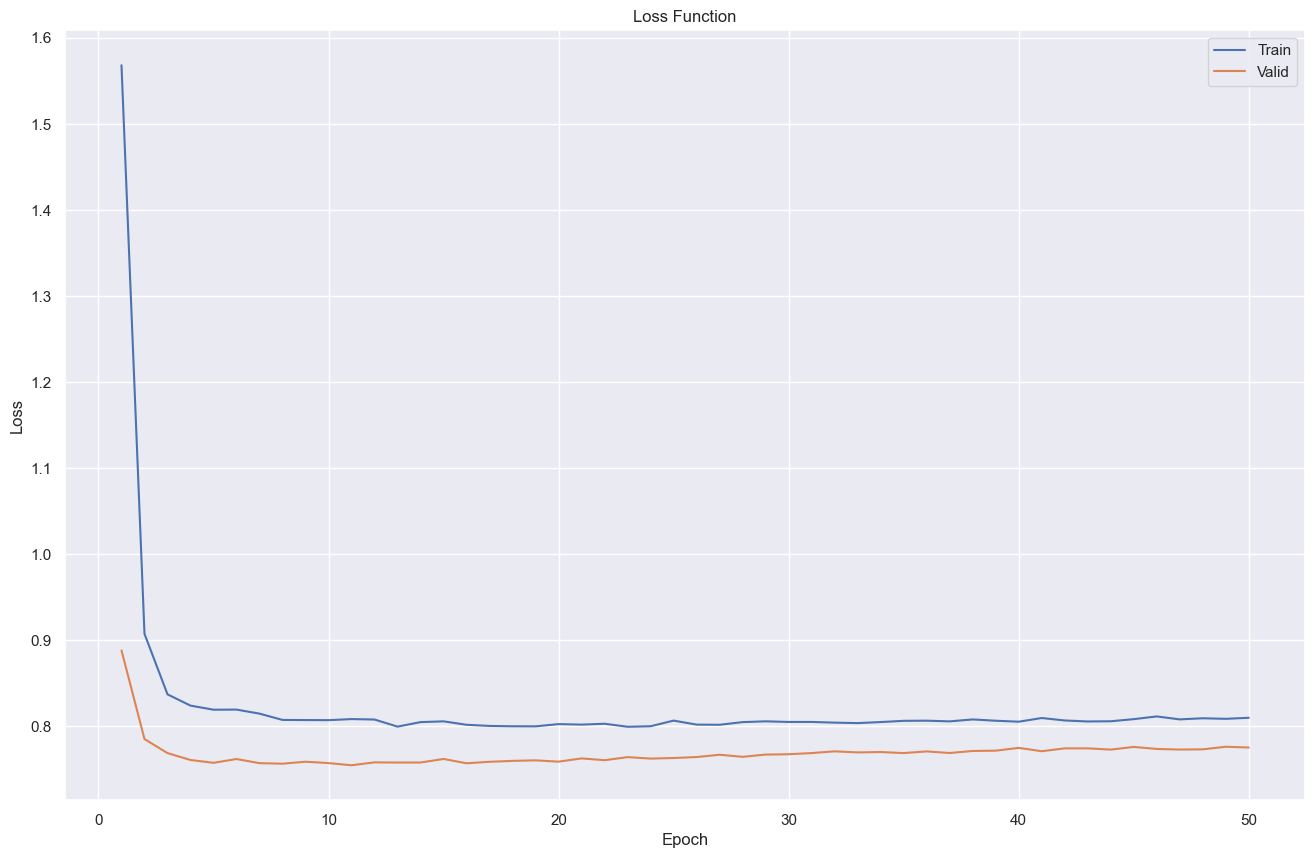

In [23]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'Loss Function',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

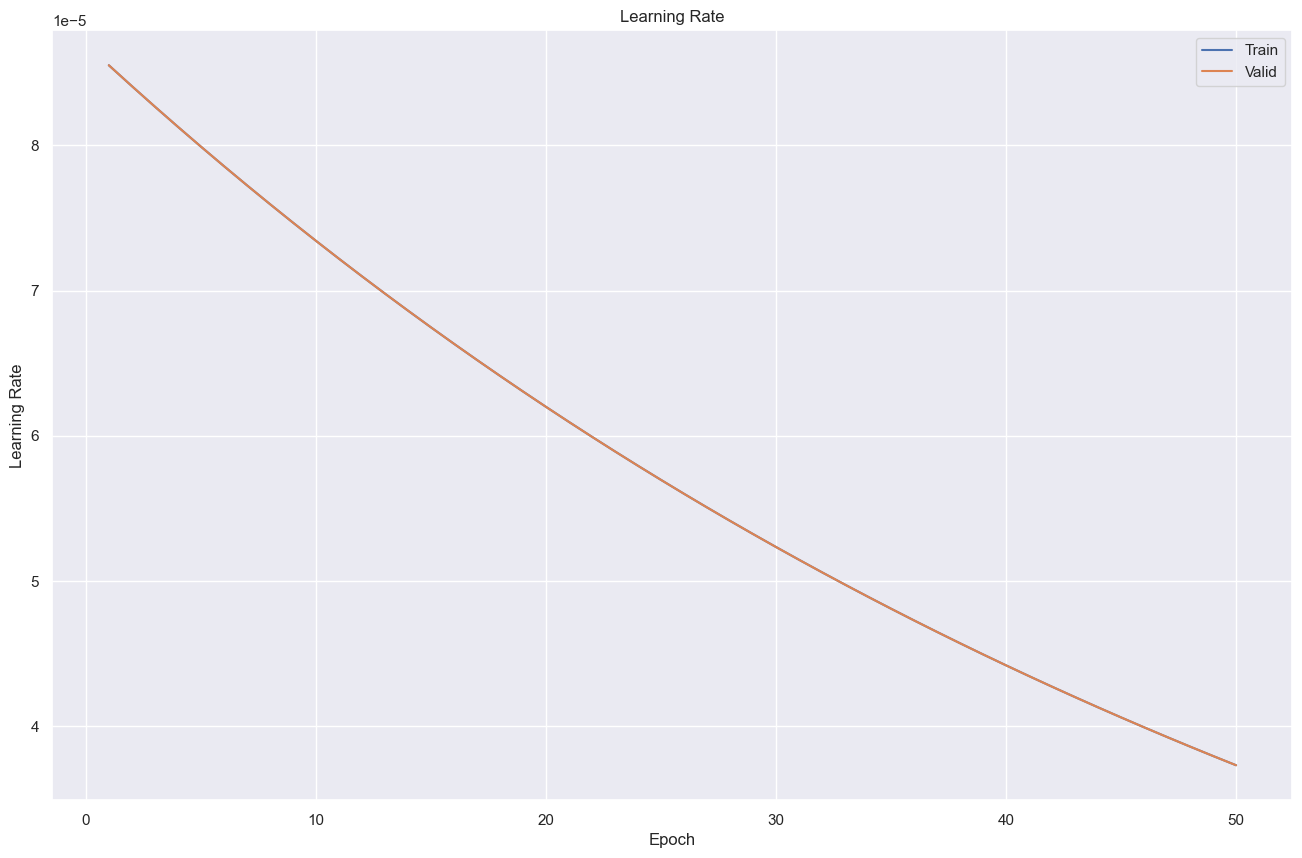

In [24]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Learning Rate',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

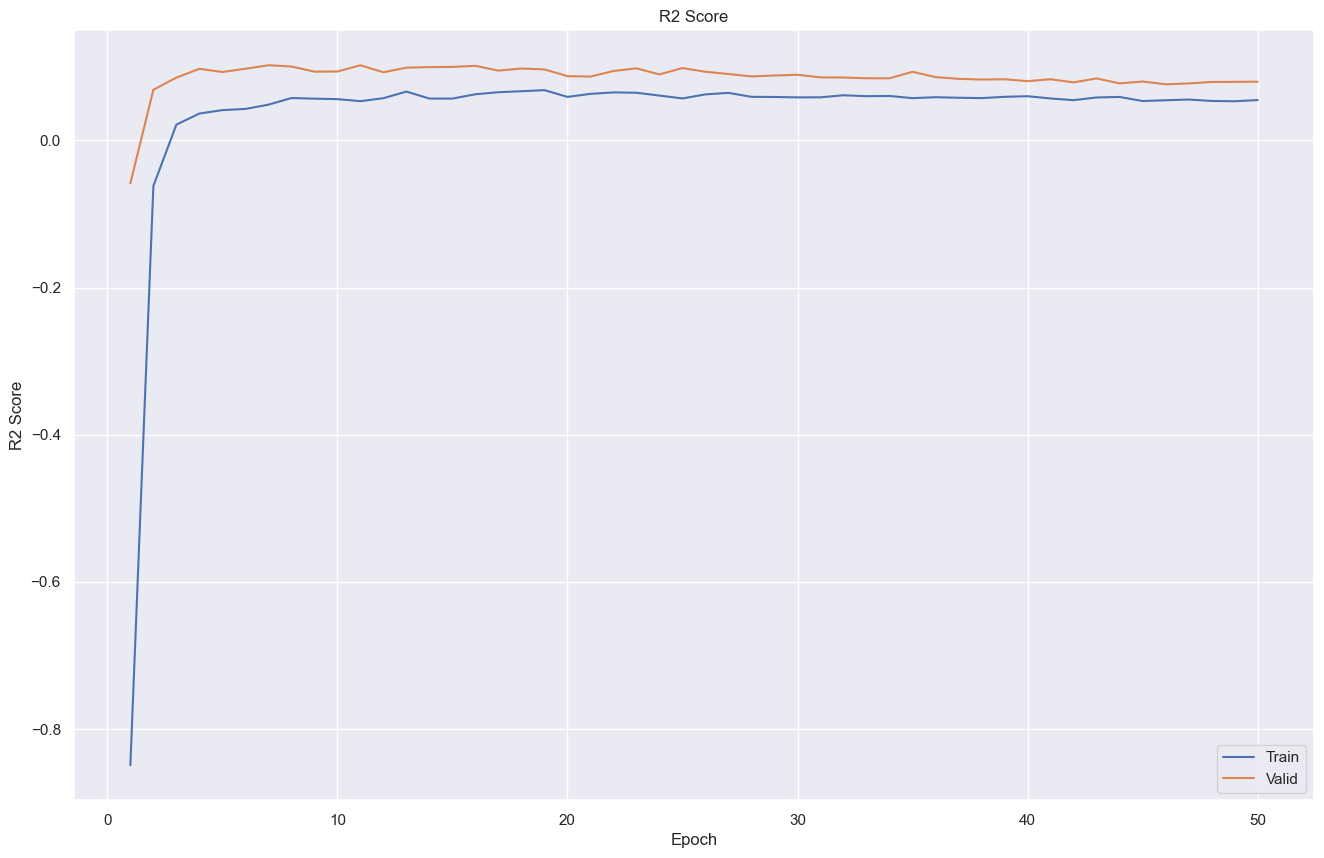

In [25]:
# Display the training and validation accuracy or r2 curves

if CONFIG['model/mode'] == 'regression' :
	cnn_plot.show_r2(
		report   = report,
		title    = 'R2 Score',
		filename = os.path.join(OUT_PLOT, model.__name__)
	)

if CONFIG['model/mode'] == 'classification' :
	cnn_plot.show_accuracy(
		report   = report,
		title    = 'Accuracy',
		filename = os.path.join(OUT_PLOT, model.__name__)
	)

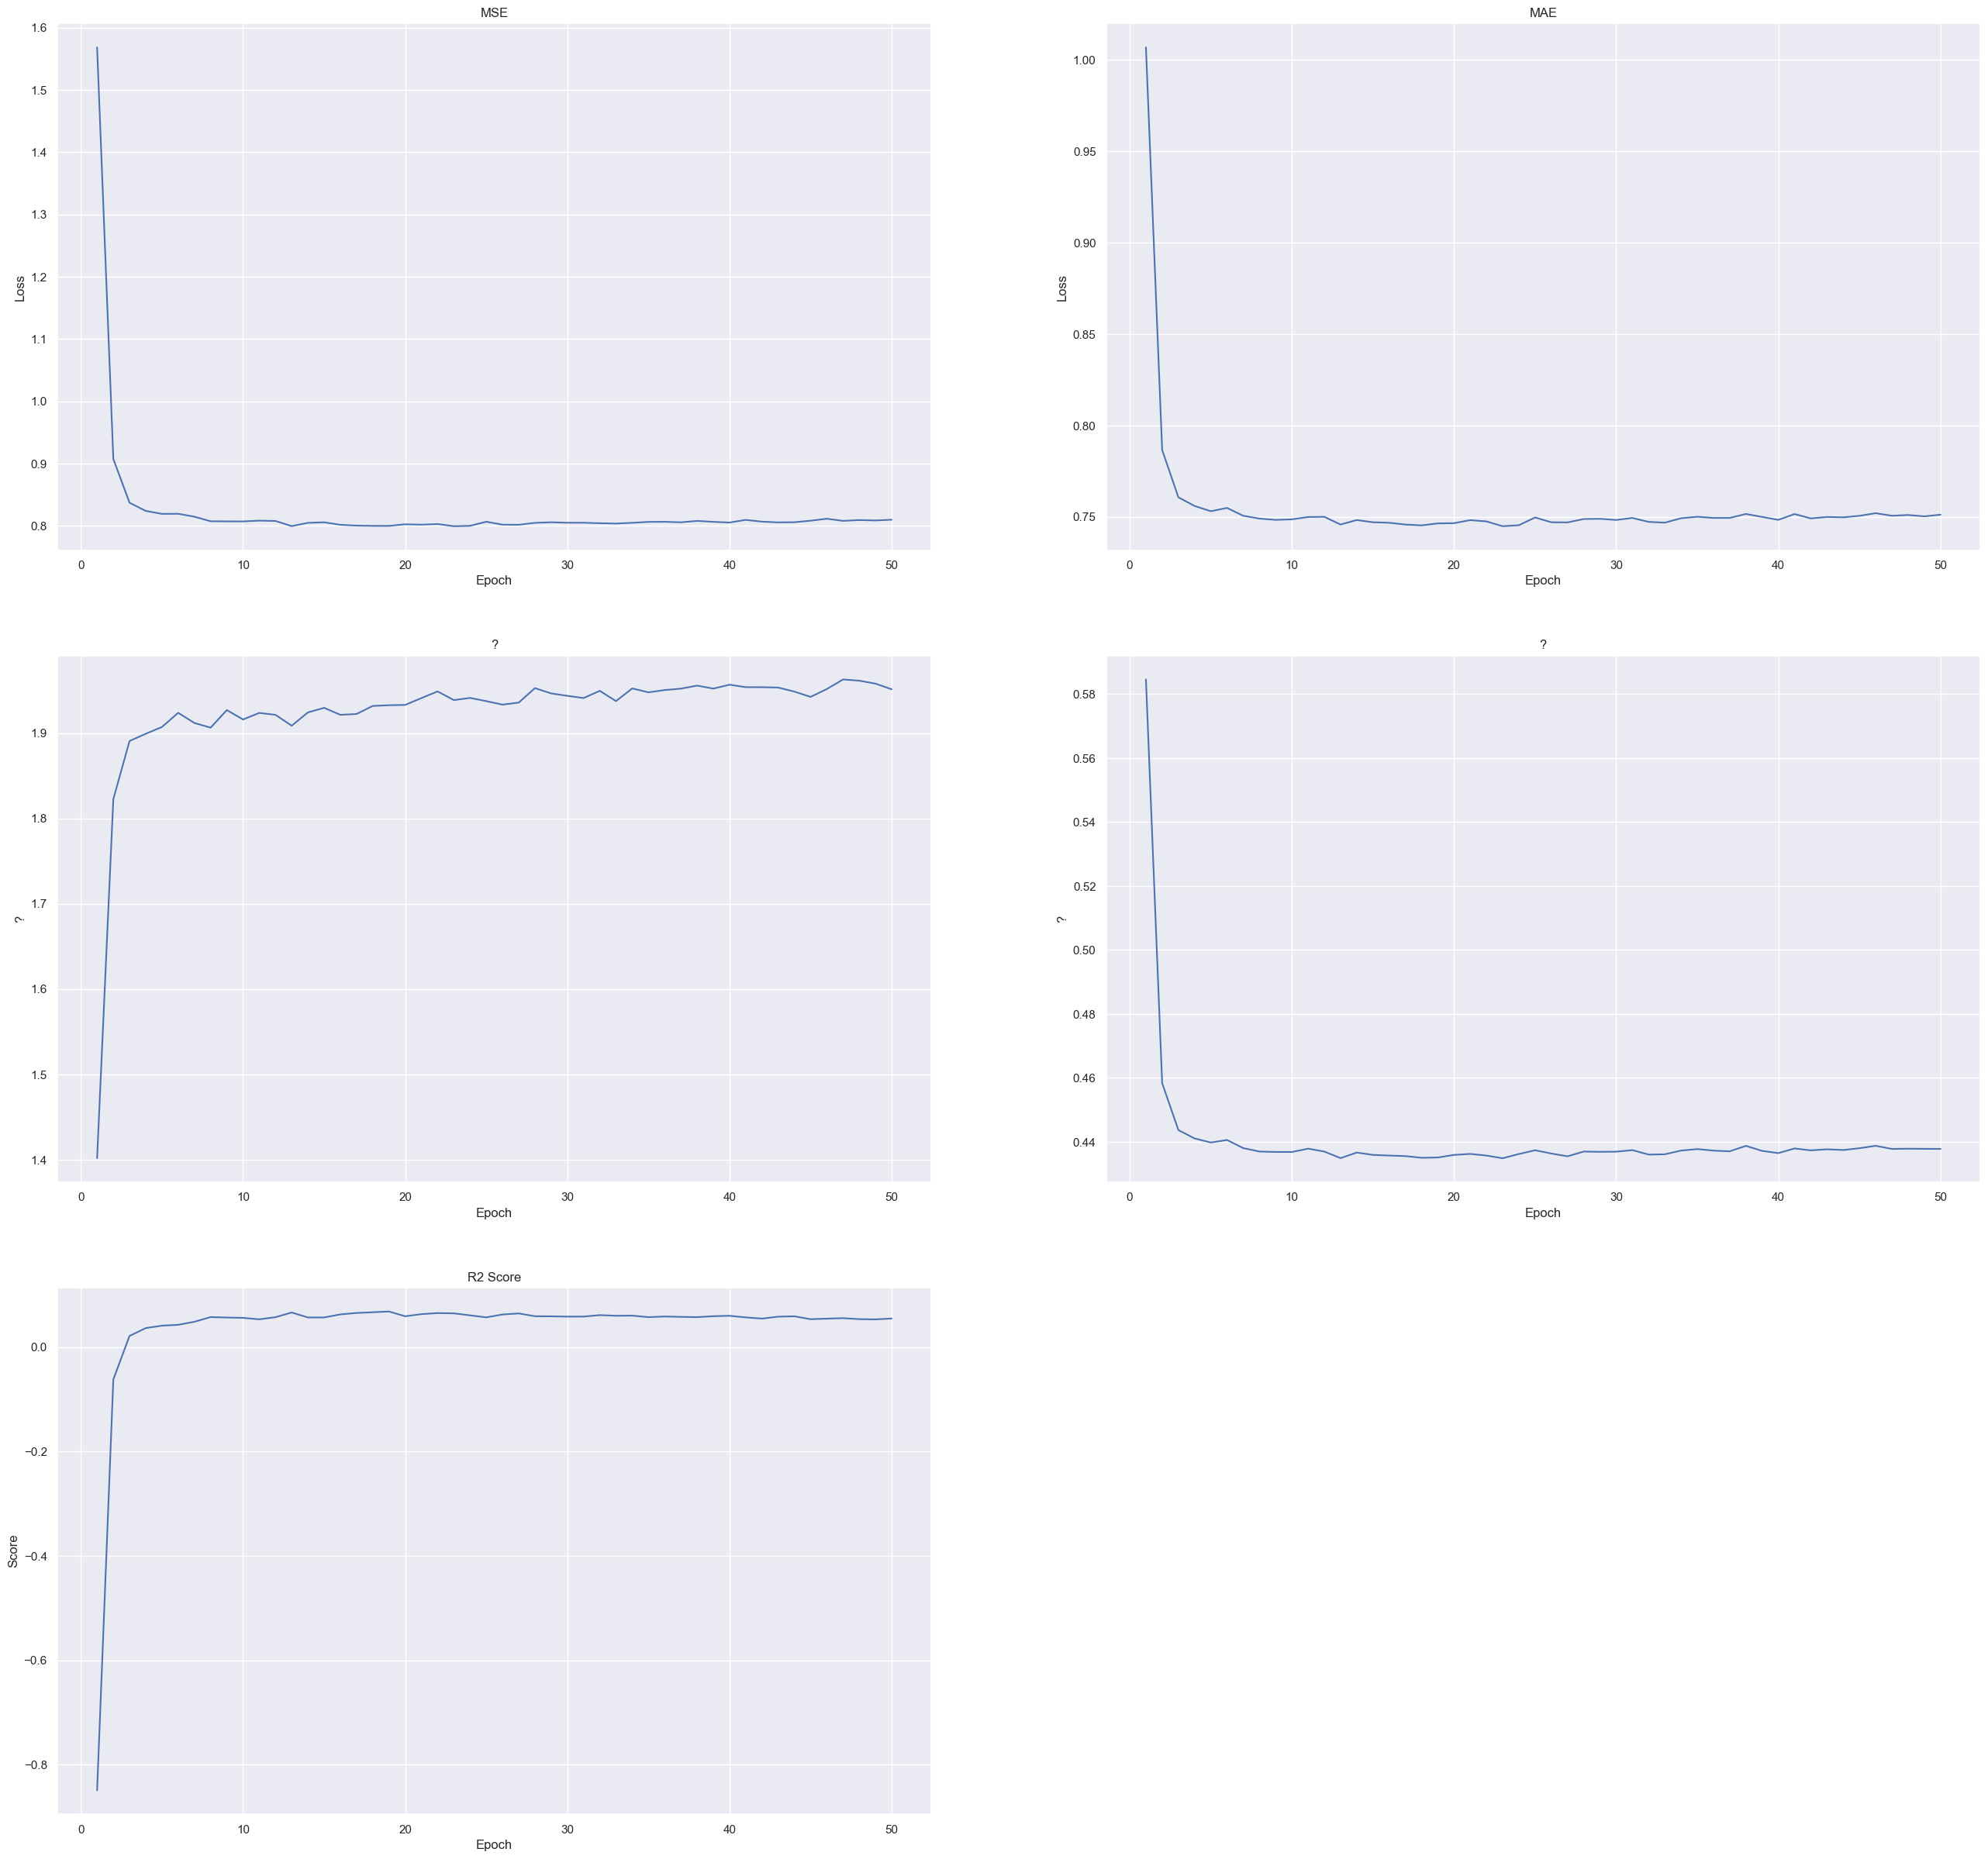

In [26]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

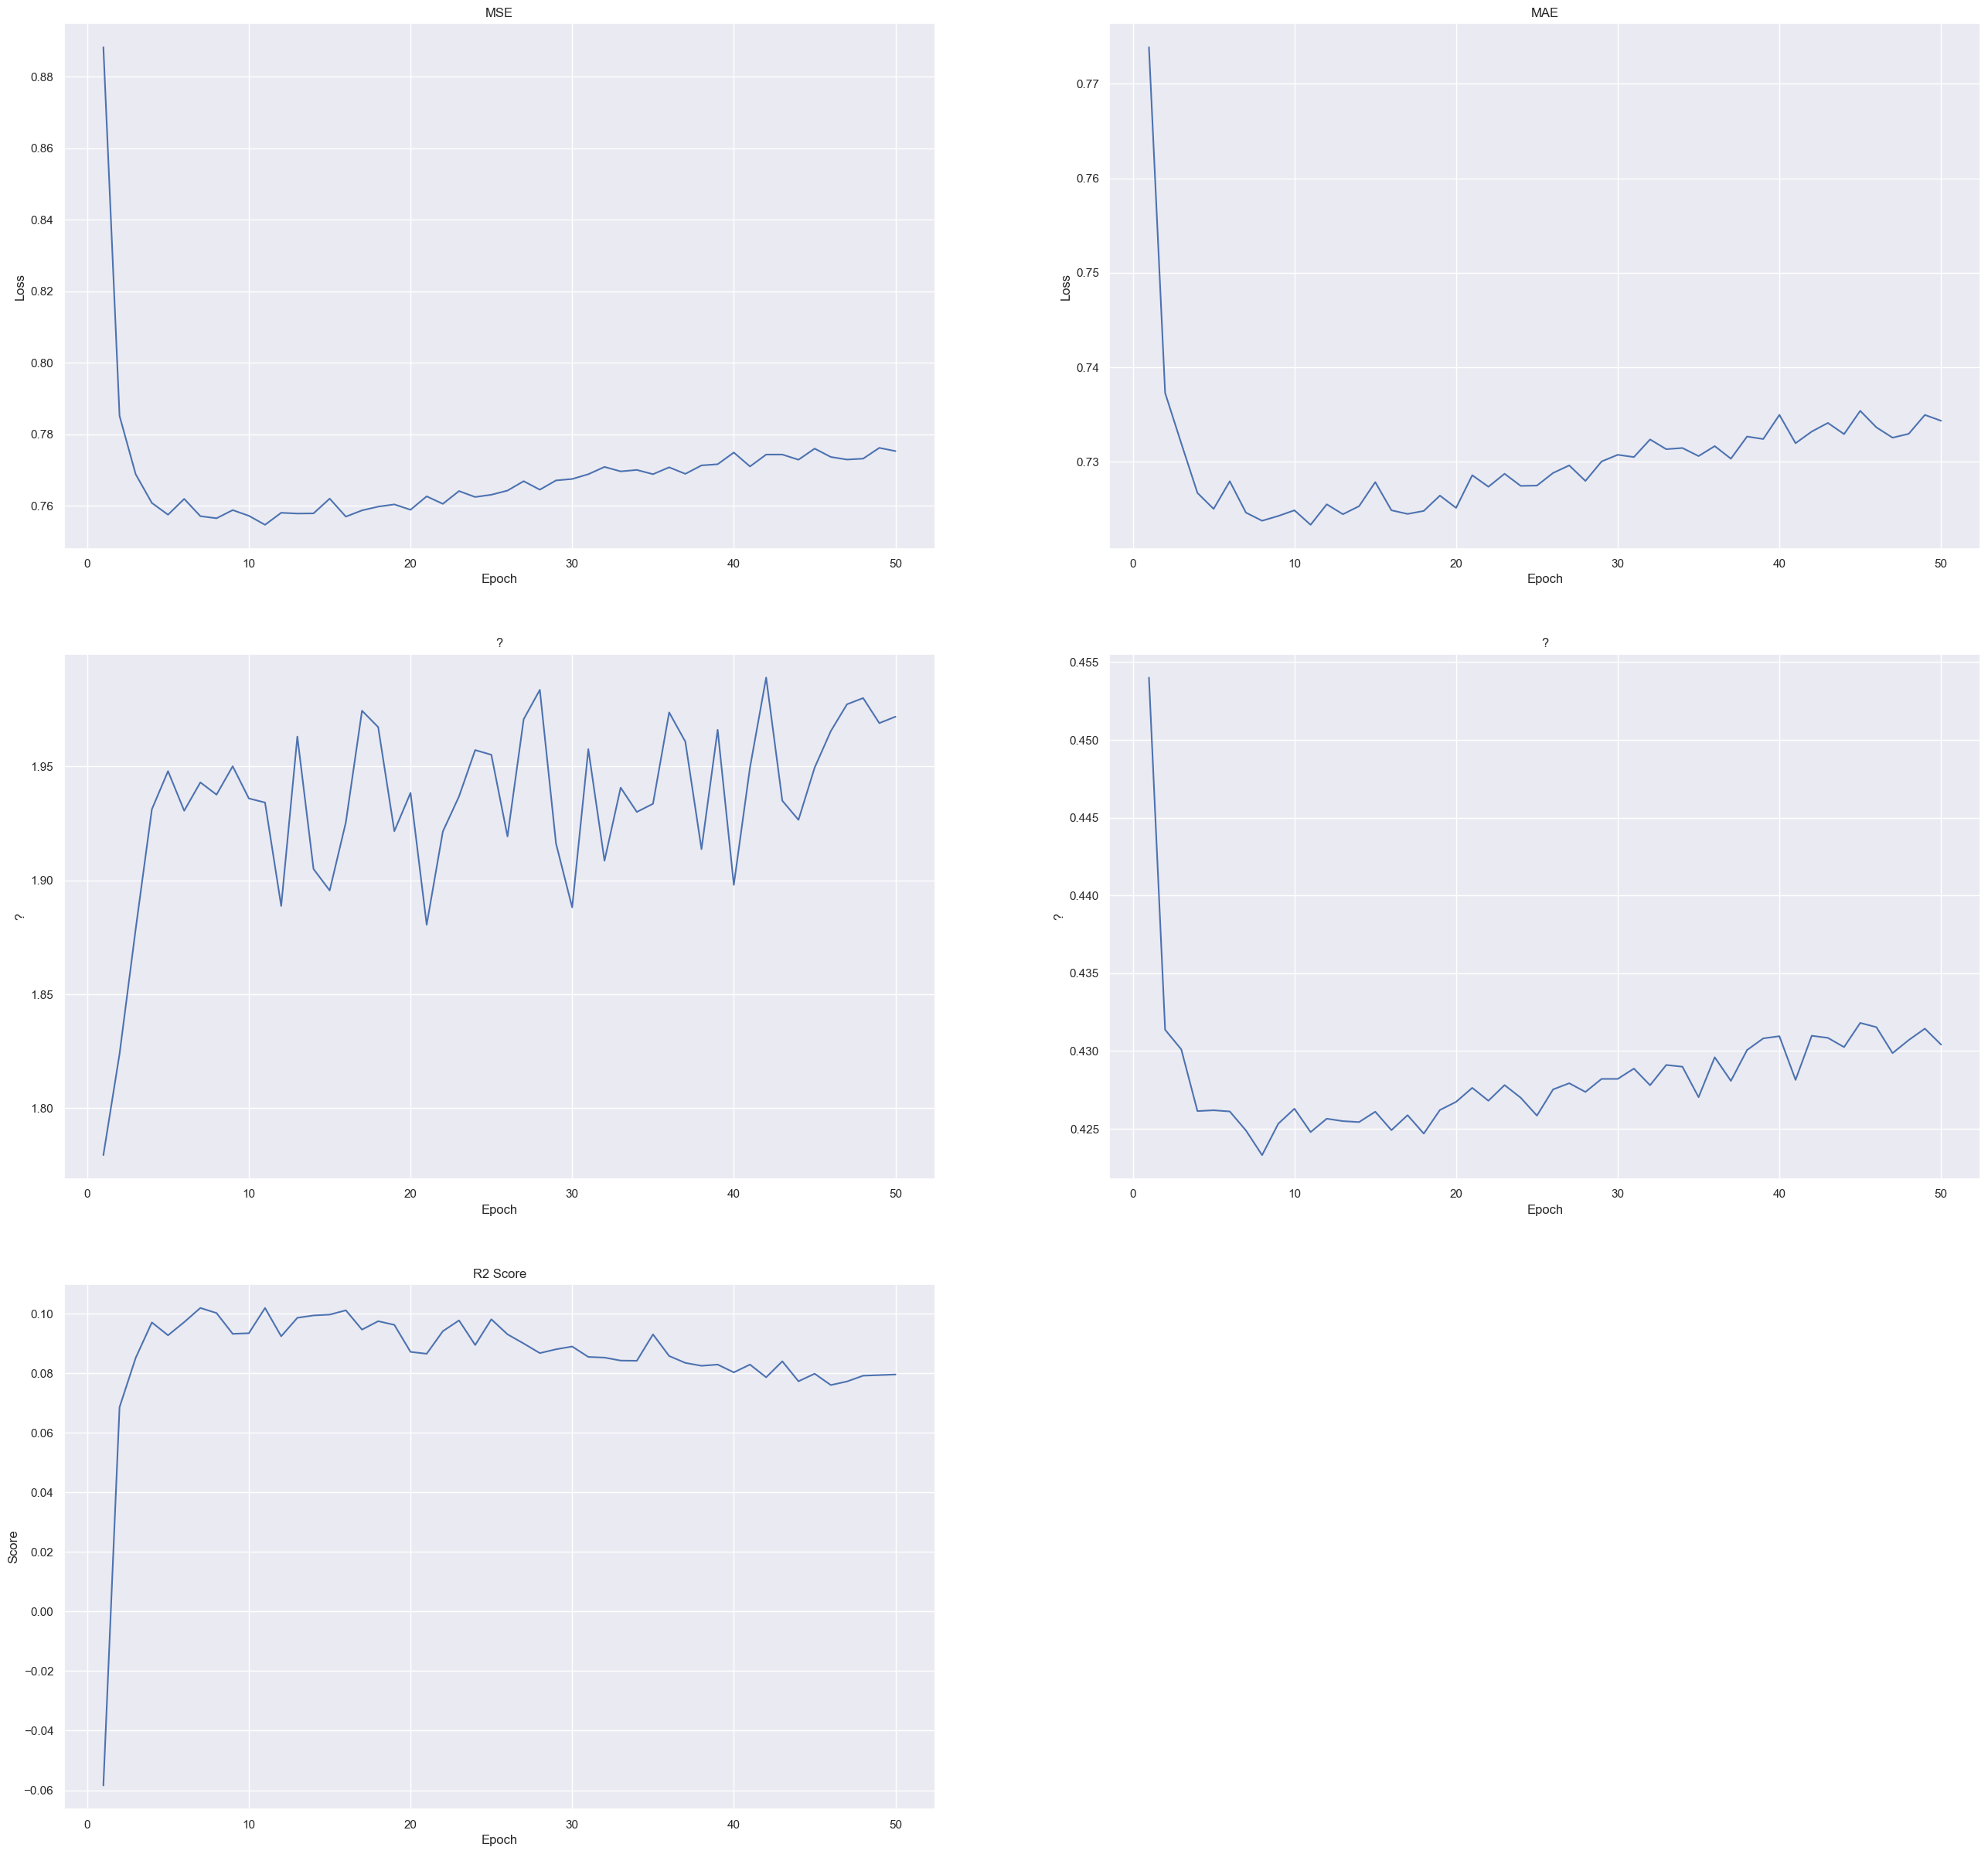

In [27]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)